In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39949")
client

<Client: 'tcp://127.0.0.1:39949' processes=8 threads=40, memory=157.36 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import xrft
import xwavelet
from scipy.interpolate import griddata
from scipy.stats import bootstrap
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
# from fastjmd95 import rho as densjmd95
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
ddir = '/tank/groups/climode/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
savedir = '/tank/topog/tuchida/Wavelet-spectrum/'
tdgs = '/tank/tdgs/tuchida/TWA/'
topog = '/tank/topog/tuchida/TWA/'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

xchunk = 100
ychunk = 100

In [5]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1419120,1574640+dnf,dnf).reshape(len(years),nfile)
dd = 0  # 
yystart = 0
ntimes[yystart,:]

array([1419120, 1421280, 1423440, 1425600, 1427760, 1429920, 1432080,
       1434240, 1436400, 1438560, 1440720, 1442880, 1445040, 1447200,
       1449360, 1451520, 1453680, 1455840, 1458000, 1460160, 1462320,
       1464480, 1466640, 1468800, 1470960, 1473120, 1475280, 1477440,
       1479600, 1481760, 1483920, 1486080, 1488240, 1490400, 1492560,
       1494720, 1496880, 1499040, 1501200, 1503360, 1505520, 1507680,
       1509840, 1512000, 1514160, 1516320, 1518480, 1520640, 1522800,
       1524960, 1527120, 1529280, 1531440, 1533600, 1535760, 1537920,
       1540080, 1542240, 1544400, 1546560, 1548720, 1550880, 1553040,
       1555200, 1557360, 1559520, 1561680, 1563840, 1566000, 1568160,
       1570320, 1572480, 1574640])

In [6]:
xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]

ntheta = 36
xo = 50e3
# s = xr.DataArray(np.arange(.5,10.5,.5), dims=['scale'], 
#                  coords={'scale':np.arange(.5,10.5,.5)}
#                 )

In [7]:
nmembs = np.arange(100,148)
iiter = 1419120

for nmemb in nmembs:
    if nmemb == 100:
        ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                     % (nmemb)), 
                             grid_dir=gdir,
                             prefix=['snap_diagOcn'], delta_t=2e2,
                             iters=iiter, 
                            ).sel(YC=slice(yNstart-12**-1,yend+2*12**-1),
                                  YG=slice(yNstart-12**-1,yend+2*12**-1)
                                 ).chunk({'XC':xchunk,'XG':xchunk,
                                          'YC':ychunk,'YG':ychunk}
                                        ).isel(time=0,Z=[14,18,24])
    else:
        ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                                    % (nmemb)), 
                                            grid_dir=gdir,
                                            prefix=['snap_diagOcn'], delta_t=2e2,
                                            iters=iiter, 
                                           ).sel(YC=slice(yNstart-12**-1,yend+2*12**-1),
                                                 YG=slice(yNstart-12**-1,yend+2*12**-1)
                                                ).chunk({'XC':xchunk,'XG':xchunk,
                                                         'YC':ychunk,'YG':ychunk}
                                                       ).isel(time=0,Z=[14,18,24])
                       ], dim='nmemb')
        
ds.coords['nmemb'] = ('nmemb',nmembs)
ds = ds.chunk({'nmemb':6})      

In [8]:
dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn'], delta_t=2e2,
                      iters=iiter, 
                     ).isel(time=0,Z=[14,18,24])

In [9]:
v = (ds.VVEL-dsb.VVEL).where(ds.maskS!=0.)
u = (ds.UVEL-dsb.UVEL).where(ds.maskW!=0.)
        
coords = {
    "Y": {"center": "YC", "left": "YG"},
    "X": {"center": "XC", "left": "XG"}
}
grid = Grid(ds, periodic=['X'], coords=coords)

In [10]:
KE = .5*(grid.interp(u**2,'X') 
         + grid.interp(v**2,'Y',boundary='extend'))
KE

<xarray.DataArray (nmemb: 48, Z: 3, YC: 423, XC: 1000)>
dask.array<mul, shape=(48, 3, 423, 1000), dtype=float32, chunksize=(6, 3, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 14.92 15.0 15.08 15.17 15.25 ... 49.83 49.92 50.0 50.08
  * Z        (Z) >f4 -227.6 -452.4 -1.137e+03
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
fig.set_tight_layout(True)
im = ax.pcolormesh(ds.XC, ds.YC, 
                   KE.isel(Z=1).mean('nmemb',skipna=True),
                   norm=clr.LogNorm(vmin=5e-4, vmax=.2), 
                   cmap='hot', rasterized=True
                  )
ax.pcolormesh(ds.XC, ds.YC, ds.maskC.where(ds.maskC==0).isel(Z=1),
              vmin=-2, vmax=1, cmap='gray', rasterized=True)
cbar = fig.colorbar(im, ax=ax, shrink=.5)
cbar.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)

ax.set_ylabel(r"Latitude", fontsize=13)
ax.set_xlabel(r"Longitude", fontsize=13)

ax.set_aspect('equal')

plt.savefig(op.join(savedir,'Figs/EKE_Z%04d_%010d.pdf' 
                    % (KE.isel(Z=1).Z.data,iiter)))

$$ K = \frac{1}{2}(a^2 + d^2) = \frac{1}{2}\langle u'^2 + v'^2\rangle\,,$$

$$ L = \frac{1}{2}(a^2 - d^2) = \frac{1}{2}\sqrt{\langle u'^2 - v'^2\rangle^2 + 4\langle u'v'\rangle^2}\,, $$

$$ \theta = \frac{1}{2}\arctan\left(\frac{2\langle u'v'\rangle}{\langle u'^2 - v'^2\rangle}\right)\,, $$

In [11]:
LE = .5 * np.sqrt((grid.interp(u**2,'X') - grid.interp(v**2,'Y',boundary='extend')
                  ).mean('nmemb',skipna=True)**2
                  + 4*(grid.interp(u,'X')*grid.interp(v,'Y',boundary='extend')
                      ).mean('nmemb',skipna=True)**2
                 )
LE

<xarray.DataArray (Z: 3, YC: 423, XC: 1000)>
dask.array<mul, shape=(3, 423, 1000), dtype=float32, chunksize=(3, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 14.92 15.0 15.08 15.17 15.25 ... 49.83 49.92 50.0 50.08
  * Z        (Z) >f4 -227.6 -452.4 -1.137e+03

In [12]:
a = np.sqrt(KE.mean('nmemb',skipna=True) + LE)
b = np.sqrt(KE.mean('nmemb',skipna=True) - LE)

In [13]:
theta = .5*np.arctan(2*(grid.interp(u,'X') * grid.interp(v,'Y',boundary='extend')
                       ).mean('nmemb',skipna=True)
                     / (grid.interp(u**2,'X') - grid.interp(v**2,'Y',boundary='extend')
                       ).mean('nmemb',skipna=True)
                    )

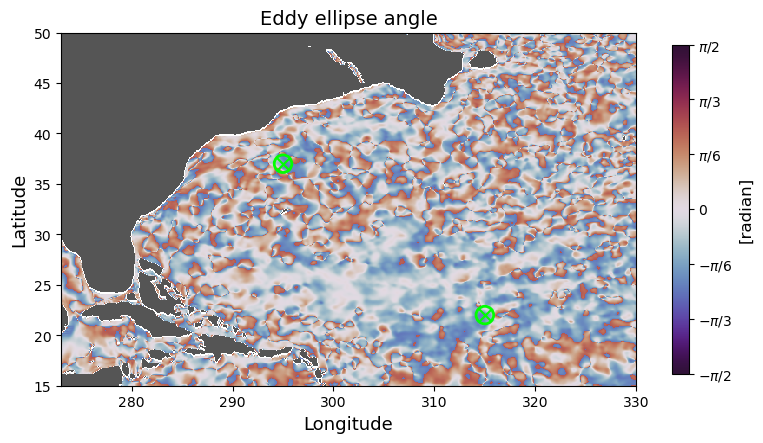

In [15]:
fig, ax = plt.subplots(figsize=(8,5))
fig.set_tight_layout(True)

im = ax.pcolormesh(ds.XC, ds.YC, theta.isel(Z=1),
                   vmax=np.pi/2, vmin=-np.pi/2, 
                   cmap='twilight_shifted', rasterized=True)

ax.pcolormesh(ds.XC, ds.YC, ds.maskC.where(ds.maskC==0).isel(Z=1),
              vmin=-1, vmax=2, cmap='gray', rasterized=True)

re = 1e0
# for i in ds.XC.sel(XC=slice(273,330)):
#     for j in ds.YC.sel(YC=slice(15,50)):
#         # if j < 45:
#             # area = np.pi*a.isel(Z=0).sel(XC=i, YC=j)*b.isel(Z=0).sel(XC=i, YC=j)
#         try:
#             ax.plot(xx.sel(XC=i, YC=j)[0]/a.isel(Z=1).sel(XC=i, YC=j)*re+i, 
#                     xx.sel(XC=i, YC=j)[1]/a.isel(Z=1).sel(XC=i, YC=j)*re+j, 
#                     'k', alpha=.7)
#         except:
#             pass
        
ax.set_ylim([15,50])
ax.set_xlim([273,330])

ax.scatter(xs[0], ys[0], marker='x', s=80, c='lime')
ax.scatter(xs[0], ys[0], marker='o', s=160, facecolors='none', edgecolors='lime', linewidths=2)
ax.scatter(xs[-1], ys[-1], marker='x', s=80, c='lime')
ax.scatter(xs[-1], ys[-1], marker='o', s=160, facecolors='none', edgecolors='lime', linewidths=2)

# fig.subplots_adjust(right=0.86, hspace=.16, wspace=.15) 
# cbax = fig.add_axes([0.88, 0.275, 0.016, 0.45])
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=.7,
                    ticks=[-np.pi/2,-np.pi/3,-np.pi/6,0,np.pi/6,np.pi/3,np.pi/2]
                   )
cbar.ax.set_yticklabels([
    r"$-\pi/2$",r"$-\pi/3$",r"$-\pi/6$",r"$0$",r"$\pi/6$",r"$\pi/3$",r"$\pi/2$"
])
cbar.set_label(r"[radian]", fontsize=12)
ax.set_ylabel(r"Latitude", fontsize=13)
ax.set_xlabel(r"Longitude", fontsize=13)

ax.set_aspect('equal')
ax.set_title(r"Eddy ellipse angle", fontsize=14)

plt.savefig(op.join(savedir,'Figs/Eddy-angle_Z%04d_%010d.pdf'
                    % (KE.isel(Z=1).Z.data,iiter)))

In [14]:
angles = np.linspace(-np.pi,np.pi,40)
dg = 32
xx = xr.DataArray(np.ones((2, len(angles),
                           len(b.YC[dg//2:][::dg]),
                           len(a.XC[dg//2:][::dg]))),
                  dims=['ab','angle','YC','XC'],
                  coords={'angle':angles,'YC':b.YC[dg//2:][::dg],
                          'XC':a.XC[dg//2:][::dg]}
                 ) * np.nan


for i in a.XC[dg//2:][::dg]:
    for j in b.YC[dg//2:][::dg]:
        
        rotation = np.matrix([
                      [ np.cos(theta.isel(Z=1).sel(XC=i, YC=j)), 
                       -np.sin(theta.isel(Z=1).sel(XC=i, YC=j))], 
                      [ np.sin(theta.isel(Z=1).sel(XC=i, YC=j)),  
                        np.cos(theta.isel(Z=1).sel(XC=i, YC=j))]]
                   )
        axes = np.array([a.isel(Z=1).sel(XC=i, YC=j).values*np.cos(angles),
                         b.isel(Z=1).sel(XC=i, YC=j).values*np.sin(angles)]
               )
        xx.sel(XC=i,YC=j)[:] = np.squeeze(np.asarray(np.dot(rotation, axes)))

ValueError: setting an array element with a sequence.

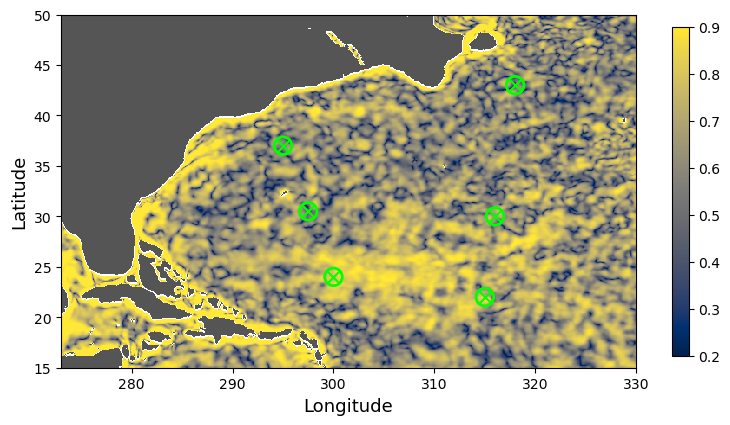

In [19]:
ecc = np.sqrt(1 - b**2/a**2)

fig, ax = plt.subplots(figsize=(8,5))
fig.set_tight_layout(True)

im = ax.pcolormesh(ds.XC, ds.YC, ecc.isel(Z=1),
                   vmax=.9, vmin=0.2, 
                   cmap='cividis', rasterized=True)

ax.pcolormesh(ds.XC, ds.YC, ds.maskC.where(ds.maskC==0).isel(Z=1),
              vmin=-1, vmax=2, cmap='gray', rasterized=True)

# re = 1e0
# for i in ds.XC.sel(XC=slice(273,330)):
#     for j in ds.YC.sel(YC=slice(15,50)):
#         # if j < 45:
#             # area = np.pi*a.isel(Z=0).sel(XC=i, YC=j)*b.isel(Z=0).sel(XC=i, YC=j)
#         try:
#             ax.plot(xx.sel(XC=i, YC=j)[0]/a.isel(Z=1).sel(XC=i, YC=j)*re+i, 
#                     xx.sel(XC=i, YC=j)[1]/a.isel(Z=1).sel(XC=i, YC=j)*re+j, 
#                     'k', alpha=.7)
#         except:
#             pass
        
ax.set_ylim([15,50])
ax.set_xlim([273,330])

ax.scatter(xs, ys, marker='x', s=80, c='lime')
ax.scatter(xs, ys, marker='o', s=160, facecolors='none', edgecolors='lime', linewidths=2)

# fig.subplots_adjust(right=0.86, hspace=.16, wspace=.15) 
# cbax = fig.add_axes([0.88, 0.275, 0.016, 0.45])
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=.7,
                    # ticks=[-np.pi/2,-np.pi/3,-np.pi/6,0,np.pi/6,np.pi/3,np.pi/2]
                   )
# cbar.ax.set_yticklabels([
#     r"$-\pi/2$",r"$-\pi/3$",r"$-\pi/6$",r"$0$",r"$\pi/6$",r"$\pi/3$",r"$\pi/2$"
# ])
# cbar.set_label(r"[radian]", fontsize=12)
ax.set_ylabel(r"Latitude", fontsize=13)
ax.set_xlabel(r"Longitude", fontsize=13)

ax.set_aspect('equal')

plt.savefig(op.join(savedir,'Figs/Eddy-eccentricity_Z%04d_%010d.pdf'
                    % (KE.isel(Z=1).Z.data,iiter)))